## Write the Hello World program on qiskit using two qubit bell-state

### step 1: Map the problem to circuits and operators
##### Basically, this step includes providing the instructions to a quantum circuit or operator for it to function. This can be done either by making a quantum circuit and adding gates to it or using operators.

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService

service=QiskitRuntimeService(channel="ibm_quantum", 
                             token="828152830a71e2a562b8f59596e4755753350f186c24c2d6005fa6192bd895b04bbfc0ba4ac15046f0f64fc077fc8a774602de307e75da8bf9c9fa8b29fc37aa")


In [40]:
#generating bell state
from qiskit import QuantumCircuit
qc=QuantumCircuit(2)        #2 indicates number of qubits we are using
qc.h(0)                     #hadamard gate on 0th qubit
qc.cx(0,1)                  #cnot on 0 and 1 position
qc.draw()       #this draws output using a library called matplotlib

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [41]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

quantum_observable = [ZZ, ZI, IZ, XX, XI, IX]

#In qiskit, we have two ways to get output of the data :
 # (1) probability distribution of the number of qubits we choose to measure
 # (2) expectation value of an observable

In [51]:
from qiskit.quantum_info import SparsePauliOp  #sparsepauliop is a class that takes in object(label) and is used to represent Pauli operators in sparse(simple) form

observable_labels = ['ZZ', 'IZ','ZI','XX','IX','XI']
observables = [SparsePauliOp(labels) for labels in observable_labels]
for observable in observables:
        print(observable)

        #if the qubits are entangled then the coeff of sparsepauliop will be 1.

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])
SparsePauliOp(['IZ'],
              coeffs=[1.+0.j])
SparsePauliOp(['ZI'],
              coeffs=[1.+0.j])
SparsePauliOp(['XX'],
              coeffs=[1.+0.j])
SparsePauliOp(['IX'],
              coeffs=[1.+0.j])
SparsePauliOp(['XI'],
              coeffs=[1.+0.j])


In [43]:
print(SparsePauliOp(ZZ))

SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j])


### step - 2: Optimising the circuits and operators (backend)
Optimisation means to make the best use of the information. Here, despite we write code in the same langugae, we need to modify it in much simpler terms customising for the backend service we are going to use.
Every backend computer has a different ISA(instruction set architecture), that is a bridge between the code we write and the hardware of the particular backend we are going to use for execution.

In [44]:
#just checking which backend service is available
#if there is none available, then the optimization might not happen and it throws error

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

available_backend = service.least_busy(simulator=False, operational = True)
print(available_backend)

<IBMBackend('ibm_kyoto')>


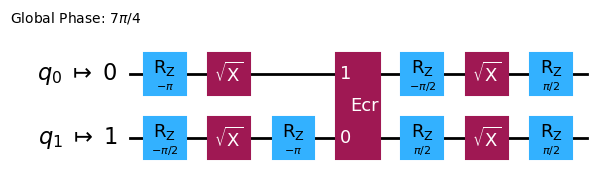

In [45]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#transpiler - this is responsible for converting high level quantum circuit into low level that can be executed on selected quantum hardware.
#pass managers - this is a collection of transformation(passes) which a traspiler applies to optimize the circuit.

service = QiskitRuntimeService() #this line initializes QRS which we will use to connect to IBMs backend.

#simulator - a software that mimics the behavior of quantum computer but operates on a classical comp.
#operational - real quantum hardware.

backend_device = service.least_busy(simulator = False , operational = True)

#optimization_level - the breakdown of the circuits is numbered on levels, higher the level, more simpler the circuit gets, takes more time to run.

pm = generate_preset_pass_manager(backend=backend_device, optimization_level=1)
isa_circuit = pm.run(qc)
isa_circuit.draw(output='mpl', idle_wires=False)

### step - 3: Execution using primitive 'estimator'
Since the quantum results are randon(unpredictable), we run the circuit many times. To find the average values of observables, we use Estimator. It a one of the type of primitive (other is sampler - used to gather raw data).


In [46]:
from qiskit_aer.primitives import Estimator
estimator = Estimator()
job = estimator.run([qc] * len(quantum_observable), quantum_observable)
job.result()

EstimatorResult(values=array([ 1.        , -0.04296875, -0.04296875,  1.        ,  0.05664062,
        0.05664062]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0067126, 'sample_measure_time': 0.0011885, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 32012, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9981536865234375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0067126, 'sample_measure_time': 0.0011

In [52]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
estimator = Estimator(mode=backend_device)
estimator.options.resilience_level = 1 #if this throws an error, import RuntimeOptions from quantum_ibm_runtime
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cv4r1pehdzz0008m12j0


#### once the job is executed on the backend, we can fetch the job results

In [56]:
job_result = job.result()
pub_result =job.result()[0]

### Step - 4 : Analyzing the results
herein, we just have to utilize the results that we got after execution. we can fetch it to some other workflow.
in this example we are going to plot this data into a map for visualization.

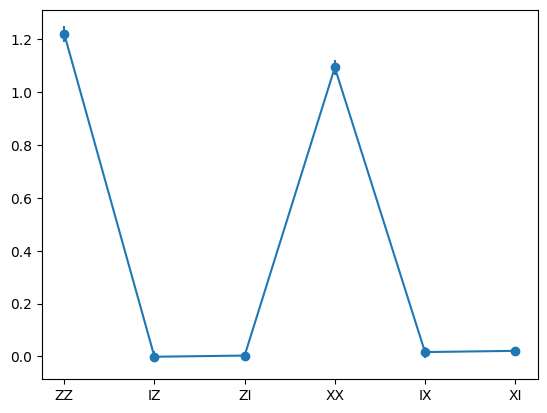

In [64]:
from matplotlib import pyplot as plt

values = pub_result.data.evs
errors = pub_result.data.stds

# plt.plot = (observable_labels, values,'-o')   #idk why this aint working
plt.errorbar(observable_labels, values, yerr=errors, fmt='-o')  #if we are plotting errors as well on the graph then use "errorbar"
plt.xlabel = ('observables')
plt.ylabel = ('values')
plt.show()